# MFE 230M Homework 2
## Alexander Damiani, Zhongnan Fang, Linshan Li, Kunming Wu

In [86]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import Hull_White as hw
import mortgage_np as m
import Discount_Functions as disc_func
import itertools
import matplotlib.pyplot as plt

import MFE230M_HW2_main as hw2_module
import imp
hw2_module = imp.reload(hw2_module)

%matplotlib inline

In [87]:
r0 = 0.01816
dr = 10e-5

# increase the number of simulations to increase accuracy
# 1000 path (actually it's 2000 because of antithetic paths) provides a fairly good estimate already
hw2_module.num_sims = 1000
num_sims = hw2_module.num_sims

# Question a, b, c: 
### Using non-time-varying hazard model
### The parameters estimated from MATLAB are:

Values:
- gamma = 0.0568
- p = 2.9025
- beta_1 = -12.6051
- beta_2 = -2.0992

SE:
- gamma_se = 0.0018
- p_se = 0.0750
- beta_1_se = 1.9998
- beta_2_se = 0.0495

Given the matlab code (prop_haz.m) we can know that estimating hazard function follows the following formula:

$$
\begin{align*}
\lambda(t) &= Pr(\tau = t | \tau>t-1,v)\\
           &= \frac{\gamma p(\gamma t)^{p-1}}{1+(\gamma t)^p} e^{\beta v}\\
\end{align*}
$$

where the covariates v are:
- Difference between "contract mortgage rate" and "the 3 month lag of the 10 year LIBOR rate".
- Indicator for summer months.

From the formula, we know $\gamma$ is the magnitude of the baseline hazard, and $p$ is the shape parameter for the baseline hazard. The last two parameters are coefficients for covariates, which are $\beta_1$ and $\beta_2$. 

$\beta_1$ measures how borrowers react to coupoon gaps and $\beta_2$ measures the sensitivity to the summer months.

## Get V, V+, V- 

In [81]:
(bond_prices, standard_errors, summary_CF, summary_CF_anti, 
 r_matrix, r_anti_matrix, cum_df_matrix, cum_df_anti_matrix,
 pricing_arr, pricing_arr_anti, r_matrix_original_part_abc, r_anti_matrix_original_part_abc) = hw2_module.get_V(r0)

(bond_prices_p, standard_errors_p, summary_CF_p, summary_CF_anti_p,
 r_matrix_p, r_anti_matrix_p, cum_df_matrix_p, cum_df_anti_matrix_p,
 pricing_arr_p, pricing_arr_anti_p, r_matrix_original_p, r_anti_matrix_original_p)= hw2_module.get_V(r0+dr)

(bond_prices_m, standard_errors_m, summary_CF_m, summary_CF_anti_m,
 r_matrix_m, r_anti_matrix_m, cum_df_matrix_m, cum_df_anti_matrix_m,
 pricing_arr_m, pricing_arr_anti_m, r_matrix_original_m, r_anti_matrix_original_m) = hw2_module.get_V(r0-dr)

...........................................................................................
...........................................................................................
...........................................................................................
...........................................................................................
...........................................................................................
...........................................................................................


# Residual Class

In [82]:
residual_arr = hw2_module.get_residual_V(r0,summary_CF, summary_CF_anti, r_matrix, r_anti_matrix, cum_df_matrix, cum_df_anti_matrix)
res_V0 = np.mean(residual_arr)
res_std = np.std(residual_arr) / math.sqrt(num_sims)

residual_arr_p = hw2_module.get_residual_V(r0+dr,summary_CF_p, summary_CF_anti_p, r_matrix_p, r_anti_matrix_p, cum_df_matrix_p, cum_df_anti_matrix_p)
res_V_plus = np.mean(residual_arr_p)

residual_arr_m = hw2_module.get_residual_V(r0-dr,summary_CF_m, summary_CF_anti_m, r_matrix_m, r_anti_matrix_m, cum_df_matrix_m, cum_df_anti_matrix_m)
res_V_minus = np.mean(residual_arr_m)

# Duration

In [83]:
HW = hw.Hull_White()
bond_prices_p = [float('%.3f' % x) for x in bond_prices_p]
bond_prices_m = [float('%.3f' % x) for x in bond_prices_m]

# Calculate effective duration
eff_durs = HW.Effective_Duration(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_durs = [float('%.3f' % x) for x in eff_durs]

res_dur = HW.Effective_Duration(res_V0, res_V_plus, res_V_minus, dr)

# Convexity

In [88]:
# Calculate effective convexity
eff_conv = HW.Effective_Convexity(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_conv = [float('%.3f' % x) for x in eff_conv]
res_conv = HW.Effective_Convexity(res_V0, res_V_plus, res_V_minus, dr)

# OAS

In [89]:
final_oas_arr = hw2_module.get_OAS(pricing_arr, pricing_arr_anti, r_matrix, r_anti_matrix)

.....................................................................................................
.....................................................................................................


# Build Dataframe for Results

In [90]:
# merge results into dataframe
cols = (pricing_arr[0]).columns
cols = cols[:len(cols)-1]
df = pd.DataFrame([bond_prices, standard_errors, eff_durs, eff_conv, final_oas_arr], columns = cols,
                  index=['Bond Prices', 'Standard Errors', 'Effective Duration', 'Effective Convexity','OAS'])
df['R'] = [res_V0, res_std, res_dur, res_conv, np.nan]
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df

,CG,VE,CM,GZ,TC,CZ,CA,CY,R
Bond Prices,76749766.389,5365537.899,14545439.966,23010909.960,21018893.842,25316778.641,33577119.959,14668759.362,285978.800
Standard Errors,3628.683,366.655,1926.761,5031.398,6439.496,21266.995,2930.147,7698.641,653.300
Effective Duration,0.893,1.102,1.376,1.679,1.947,2.967,1.109,2.398,-21.934
Effective Convexity,1.926,2.348,3.560,5.015,6.123,11.421,2.771,8.424,-51.041
OAS,0.027,0.010,0.016,0.023,0.022,0.015,0.025,0.017,nan


## Discussion for part c: interpretation  for duration and convexity

Tjhey are generally in the same range as that of HW1. It makes sense that all duration and convexity are postive except the residual class and the residual class should have negative duration and convexity.

# Question d, e, f: 
### Using time-varying hazard model
### The parameters estimated from MATLAB are:

Values:
- gamma = 0.0048375
- p = 1.31377
- beta_1 = 69.75265
- beta_2 = -0.4082

SE:
- gamma_se = 0.00044725
- p_se = 0.029356
- beta_1 = 3.00396
- beta_2 = 0.04584

The economics ideas are quite similar after considering the time-varying feature of the hazard model.

From the formula, we know $\gamma$ is the magnitude of the baseline hazard, and $p$ is the shape parameter for the baseline hazard. The last two parameters are coefficients for covariates, which are $\beta_1$ and $\beta_2$.

$\beta_1$ measures how borrowers react to coupoon gaps and $\beta_2$ measures the sensitivity to the summer months.

Now, we use time-varying data to estimate the time-varying hazard model using log-logistic baseline hazard method. Compared to the result in question a, the magnitude of hazard function is 0.0048 which is slightly smaller than the non-varying model. The shape parameter $(p)$ is 1.31 which is much smaller than the shape coefficient in question a. 

The $\beta$ parameters behave quite different from question a, within time-varying model, the reaction to coupon gaps $(\beta_1)$ is strongly positive while in non-time varying model, there is a negative relation. For $\beta_2$, summer indicator used to have a negative impact on hazard rate, however, the effect diminish to zero when we use time-varying model.

### Main Difference

The main difference between the time-varying and non-varying model is that likelihood fucntion of MLE:

- non varying model

$$ \ln L(\theta) = \sum_{i \in observed} \ln \lambda(t_i | \theta) + \sum_{i \in all} \ln S(t_i| \theta) $$

- time varying model

$$ \ln L(\theta) = \sum_{i \in observed} \ln \lambda(t_i) + \sum_{i \in all} \sum_{k=1}^{N_i} \ln S(t_{ik} | t_{ik-1}) $$

# Changing Parameters

In [91]:
hw2_module.gamma = 0.0048375
hw2_module.p = 1.31377
hw2_module.beta_1 = 69.75265
hw2_module.beta_2 = -0.4082
hw2_module.beta = np.array([hw2_module.beta_1, hw2_module.beta_2])

hw2_module.num_sims = 1000
num_sims = hw2_module.num_sims

# Get V, V+, V-

In [92]:
(bond_prices, standard_errors, summary_CF, summary_CF_anti, 
 r_matrix, r_anti_matrix, cum_df_matrix, cum_df_anti_matrix,
 pricing_arr, pricing_arr_anti, r_matrix_original, r_anti_matrix_original) = hw2_module.get_V(r0)

(bond_prices_p, standard_errors_p, summary_CF_p, summary_CF_anti_p,
 r_matrix_p, r_anti_matrix_p, cum_df_matrix_p, cum_df_anti_matrix_p,
 pricing_arr_p, pricing_arr_anti_p, r_matrix_original_p, r_anti_matrix_original_p)= hw2_module.get_V(r0+dr)

(bond_prices_m, standard_errors_m, summary_CF_m, summary_CF_anti_m,
 r_matrix_m, r_anti_matrix_m, cum_df_matrix_m, cum_df_anti_matrix_m,
 pricing_arr_m, pricing_arr_anti_m, r_matrix_original_m, r_anti_matrix_original_m) = hw2_module.get_V(r0-dr)

...........................................................................................
...........................................................................................
...........................................................................................
...........................................................................................
...........................................................................................
...........................................................................................


# Residual Class

In [93]:
residual_arr = hw2_module.get_residual_V(r0,summary_CF, summary_CF_anti, r_matrix, r_anti_matrix, cum_df_matrix, cum_df_anti_matrix)
res_V0 = np.mean(residual_arr)
res_std = np.std(residual_arr) / math.sqrt(num_sims)

residual_arr_p = hw2_module.get_residual_V(r0+dr,summary_CF_p, summary_CF_anti_p, r_matrix_p, r_anti_matrix_p, cum_df_matrix_p, cum_df_anti_matrix_p)
res_V_plus = np.mean(residual_arr_p)

residual_arr_m = hw2_module.get_residual_V(r0-dr,summary_CF_m, summary_CF_anti_m, r_matrix_m, r_anti_matrix_m, cum_df_matrix_m, cum_df_anti_matrix_m)
res_V_minus = np.mean(residual_arr_m)

# Duration

In [94]:
bond_prices_p = [float('%.3f' % x) for x in bond_prices_p]
bond_prices_m = [float('%.3f' % x) for x in bond_prices_m]

# Calculate effective duration
eff_durs = HW.Effective_Duration(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_durs = [float('%.3f' % x) for x in eff_durs]

res_dur = HW.Effective_Duration(res_V0, res_V_plus, res_V_minus, dr)

# Convexity

In [95]:
# Calculate effective convexity
eff_conv = HW.Effective_Convexity(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_conv = [float('%.3f' % x) for x in eff_conv]
res_conv = HW.Effective_Convexity(res_V0, res_V_plus, res_V_minus, dr)

# OAS

In [96]:
final_oas_arr = hw2_module.get_OAS(pricing_arr, pricing_arr_anti, r_matrix, r_anti_matrix)

.....................................................................................................
.....................................................................................................


# Build Dataframe for Results

In [97]:
# merge results into dataframe
cols = (pricing_arr[0]).columns
cols = cols[:len(cols)-1]
df = pd.DataFrame([bond_prices, standard_errors, eff_durs, eff_conv, final_oas_arr], columns = cols,
                  index=['Bond Prices', 'Standard Errors', 'Effective Duration', 'Effective Convexity','OAS'])
df['R'] = [res_V0, res_std, res_dur, res_conv, np.nan]
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df

,CG,VE,CM,GZ,TC,CZ,CA,CY,R
Bond Prices,78946370.685,5432437.511,14934987.432,23399382.222,21096170.617,24699253.575,34423600.407,14549231.678,412651.926
Standard Errors,41703.907,523.690,11655.958,39272.391,28169.744,61317.488,27100.994,21682.009,2001.372
Effective Duration,2.367,1.661,3.464,4.546,4.082,5.179,3.010,4.227,-8.281
Effective Convexity,4.007,4.985,11.981,21.802,19.689,51.993,9.462,21.304,-44.528
OAS,0.016,0.010,0.012,0.008,0.007,0.002,0.012,0.005,nan


## Discussion:

Both the duration and the convexity are higher than the ones in the non time varying model. This is because the time varying model depends heavily (very high beta value) on the coupon gap, which is related to the libor rate.

# Question g

The OAS value is the option adjusted spread for the bond defined as an average spread to the riskless rate measured across all simulated cash flow trials. To get the present value of the discounted cash flows to equal the observed current market price, a constant spread is added. We are simulating future rates, but they are uncertain. Therefore, the MBS spread will be less because the homeowner’s option to prepay is valuable. The OAS reflects the spread after adjusting for this option. The option adjusted spread then equals:
            
            Option cost = static spread – option adjusted spread

The OAS for our results was positive, indicating there is an uncertainty about future interest rates. However, it is small indicating the uncertainty is not so high as to drive up costs significantly for the option of the homeowner to prepay.

# Question h

When calculating the hazard function for the non-time varying valuation, the covariates are assumed to be static over the life of the “individual” mortgage (contract). However, the hazard function for the time-varying valuation assumed the observed covariates vary over time. In terms of the non-time varying hazard function, the covariate is only evaluated at the termination period. For the time-varying covariate the covariate is evaluated at the beginning of every month.
Thus the risk period for the non-time varying mortgage is only the termination date, but there are multiple risk periods for the time-varying case. Therefore, for the time-varying hazard model is no longer a proportional model because the covariates vary differently for different mortgages.
For example, the non-time varying covariate appears like this:




| Loan ID | Summer Month | Coupon Gap|
| -- |:-:| ---:|
| 1  | 0 | 123 |


 
The time-varying covariate appears like this though:

| Loan ID | Summer Month | Coupon Gap|
| -- |:-:| ---:|
| 1  | 0 | 134 |
| 1  | 0 | 153 |
| 1  | 0 | 122 |
| 1  | 0 | 191 |

The “prop hatz.m” function uses MLE estimation to get the parameters for the hazard function for time varying and non-time varying inputs. For the non-time varying hazard function, the likelihood of payment in period t is not affected by past values of the covariates, but in the time varying case the likelihood of payment depends on the entire history of covariates. The solution to the time-varying case is to estimate the condition of survivability at the beginning of each month. So there will be one episode per loan, per month. Thus, as explained before as well there are much more inputs influencing the value of the parameters given by the MLE estimation. These parameters determine the hazard function and therefore result in different hazard functions for time varying and non-time varying inputs. 

# Non-Time-Varying Avg Hazard Rate Plots

In [98]:
hw2_module.gamma = 0.0568
hw2_module.p = 2.9025
hw2_module.beta_1 = -12.6051
hw2_module.beta_2 = -2.0992
hw2_module.beta = np.array([hw2_module.beta_1, hw2_module.beta_2])

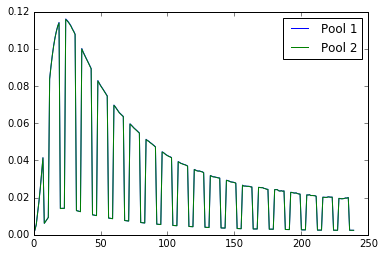

In [99]:
avg_hazard_rate_arr_pool1 = hw2_module.avg_hazard_rate(0, r_matrix_original_part_abc, r_anti_matrix_original_part_abc, num_sims)
avg_hazard_rate_arr_pool2 = hw2_module.avg_hazard_rate(1, r_matrix_original_part_abc, r_anti_matrix_original_part_abc, num_sims)
plt.plot(avg_hazard_rate_arr_pool1[0],label='Pool 1')
plt.plot(avg_hazard_rate_arr_pool2[0],label='Pool 2')
plt.legend()

# Time-Varying Avg Hazard Rate Plots

In [100]:
import imp
hw2_module = imp.reload(hw2_module)

In [101]:
hw2_module.gamma = 0.0048375
hw2_module.p = 1.31377
hw2_module.beta_1 = 69.75265
hw2_module.beta_2 = -0.4082
hw2_module.beta = np.array([hw2_module.beta_1, hw2_module.beta_2])

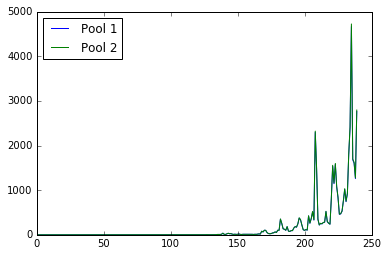

In [102]:
avg_hazard_rate_arr_pool1 = hw2_module.avg_hazard_rate(0, r_matrix_original, r_anti_matrix_original, num_sims)
avg_hazard_rate_arr_pool2 = hw2_module.avg_hazard_rate(1, r_matrix_original, r_anti_matrix_original, num_sims)
plt.plot(avg_hazard_rate_arr_pool1[0],label='Pool 1')
plt.plot(avg_hazard_rate_arr_pool2[0],label='Pool 2')
plt.legend(loc='upper left')

## Showing First 120 Months

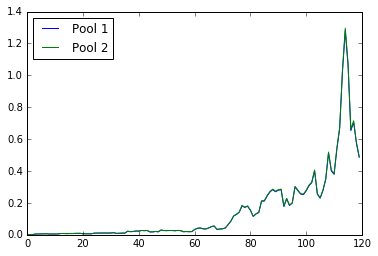

In [103]:
plt.plot(avg_hazard_rate_arr_pool1[0][:120],label='Pool 1')
plt.plot(avg_hazard_rate_arr_pool2[0][:120],label='Pool 2')
plt.legend(loc='upper left')

# Discussion

The non time varying model does a good job in modeling, and the plot makes sense to us. It shows low hazard rate in summer months. Since the model is non time varying, its simplicity requires less data and depends less on the data.

The out-of-sample situations in the time-varying model is very bad, this may due to the fact that we are using the reduced-form valuation model and also the fact that the time-varying model needs more data to train in order to achieve a better estimate. The hazard rate explore to a very large number after 7-10 years.


# Appendix

# Average 10yr 3m lagged LIBOR rates

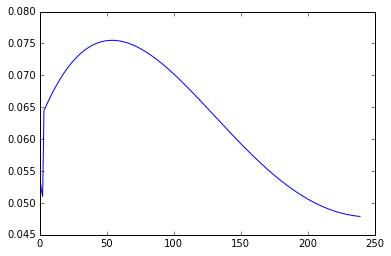

In [104]:
libor_rate_matrix = hw2_module.get_libor_rate_matrix(r_matrix_original, num_sims)
libor_rate_matrix_anti = hw2_module.get_libor_rate_matrix(r_anti_matrix_original, num_sims)
final_libor_rate_matrix = 0.5 * (libor_rate_matrix + libor_rate_matrix_anti)
plt.plot(np.asarray(final_libor_rate_matrix.mean(0))[0])
#including anti paths

# Average short rate

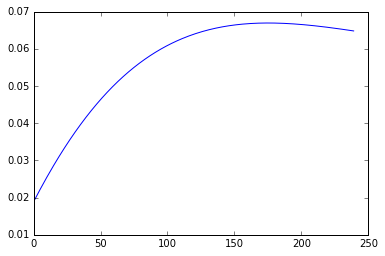

In [105]:
plt.plot(np.asarray((0.5*(r_matrix + r_anti_matrix)).mean(0)))
#including anti paths

# Average discount factor

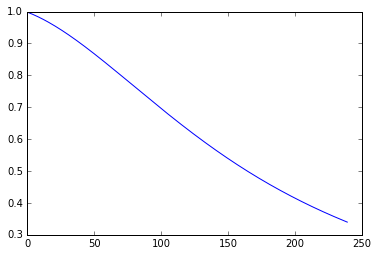

In [106]:
plt.plot(np.asarray((0.5*(cum_df_matrix+cum_df_anti_matrix)).mean(0)))